In [1]:
"""
Train on days 8 & 9
--
subm 023
predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 
'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 
'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'iadoc_mean_nc', 'ic_mean_nc']
train size:  104365809
valid size:  11596202
test size :  18790469

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.976291	val's auc: 0.975958
[20]	train's auc: 0.97987	val's auc: 0.979523
[30]	train's auc: 0.982051	val's auc: 0.981608
[40]	train's auc: 0.983125	val's auc: 0.982581
[50]	train's auc: 0.983691	val's auc: 0.983042
[60]	train's auc: 0.984024	val's auc: 0.983258
[70]	train's auc: 0.984403	val's auc: 0.983474
[80]	train's auc: 0.984647	val's auc: 0.983642
[90]	train's auc: 0.984878	val's auc: 0.983743
[100]	train's auc: 0.985067	val's auc: 0.983787
[110]	train's auc: 0.985254	val's auc: 0.983922
[120]	train's auc: 0.985415	val's auc: 0.984008
[130]	train's auc: 0.985534	val's auc: 0.984037
[140]	train's auc: 0.985662	val's auc: 0.984096
[150]	train's auc: 0.985788	val's auc: 0.984134
[160]	train's auc: 0.985895	val's auc: 0.984157
[170]	train's auc: 0.985993	val's auc: 0.984149
[180]	train's auc: 0.986095	val's auc: 0.984178
[190]	train's auc: 0.986173	val's auc: 0.984187
[200]	train's auc: 0.986252	val's auc: 0.984202
[210]	train's auc: 0.986323	val's auc: 0.984217
[220]	train's auc: 0.986392	val's auc: 0.984249
[230]	train's auc: 0.986466	val's auc: 0.984234
[240]	train's auc: 0.986546	val's auc: 0.984255
[250]	train's auc: 0.986608	val's auc: 0.984257
[260]	train's auc: 0.986667	val's auc: 0.984251
[270]	train's auc: 0.98673	val's auc: 0.984253
[280]	train's auc: 0.986789	val's auc: 0.984256
Early stopping, best iteration is:
[253]	train's auc: 0.986624	val's auc: 0.984261

Model Report
bst1.best_iteration:  253
[5459.385001420975]: model training time

"""

import os
import gc
import datetime
import time

import pandas as pd
import numpy as np
import lightgbm as lgb
import feather

import matplotlib.pyplot as plt
import seaborn as sns

inpath = '../input/'
suffix = ''
outpath = ''
savepath = ''
debug=0


In [2]:
nrows=      184903891-1
#train_size=  75000000
#val_size=     2500000
#offset=      75000000
#frm=nrows-offset
#to=frm+train_size

#day 8 starting from=68941878
#day 9 starts 131886953
#day 9 ends 184903889

#day 9 hour 4 starts; 144708152
#day 9 hour 4 ends; 148740842

train_size=  62945075
val_size=    53016936
offset=      68941878
frm=offset
to=frm+train_size+val_size


In [3]:
frm, to

(68941878, 184903889)

In [4]:


def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unique ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return df 


def DO(frm, to, fname):
    dtypes = {
            'ip'            : 'uint32',
            'app'           : 'uint16',
            'device'        : 'uint16',
            'os'            : 'uint16',
            'channel'       : 'uint16',
            'is_attributed' : 'uint8',
            'click_id'      : 'uint32',
            }
    
    print('loading train data...')
    train_df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    train_df = train_df.iloc[frm:to]
        
    gc.collect()
    
    print('loading test data...')
    test_df = feather.read_dataframe('/kaggle1/td-cache/test_base.feather')
    train_df=train_df.append(test_df)
    
    del test_df
    gc.collect()
    
    print('Extracting new features...')
    
    
    
    gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'channel', 'ip_uniq_ch', 'uint8', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'ip_device_os_cumcount_app', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'ip_day_uniq_hour', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'app', 'ip_uniq_app', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'ip_app_uniq_os', 'uint8', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip'], 'device', 'ip_uniq_device', 'uint16', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['app'], 'channel', 'app_uniq_channel', show_max=True ); gc.collect()
    train_df = do_cumcount( train_df, ['ip'], 'os', 'ip_cumcount_os', show_max=True ); gc.collect()
    train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'ip_device_os_uniq_app', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_day_hour', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
    train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()    
    train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
    train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
    train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()
    
    
    print('doing nextClick')
    #predictors=[]
    
    new_feature = 'nextClick'
    filename='nextClick_%d_%d.csv'%(frm,to)

    if os.path.exists(filename):
        print('loading from save file')
        QQ=pd.read_csv(filename, header=None)[0].values
    else:
        D=2**26
        train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
            + "_" + train_df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)

        train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-t)
            click_buffer[category]= t
        del(click_buffer)
        QQ= list(reversed(next_clicks))

        if not debug:
            print('saving')
            pd.DataFrame(QQ).to_csv(filename,index=False)
            
    to_drop = [x for x in train_df.columns if x in ['epochtime','category','click_time']]
    train_df.drop(to_drop, axis=1, inplace=True)

    train_df[new_feature] = pd.Series(QQ).astype('float32')
    #predictors.append(new_feature)

    train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
    #predictors.append(new_feature+'_shift')
    
    del QQ
    gc.collect()

    train_df['ip_day_hour'] = train_df['ip_day_hour'].astype('uint16')
    train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
    train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

    print("vars and data type: ")
    train_df.info()
    
    train_df.reset_index(drop=True, inplace=True)
    feather.write_dataframe(train_df, fname)

    return train_df
    



In [5]:
import feather
import datetime

print(datetime.datetime.now())
fname = '/kaggle1/td-cache/9793_train_from{}_to{}.feather'.format(frm, to)
#fname = '9671_train_from{}_to{}.feather'.format(frm, to)
if not os.path.exists(fname):
    print('generating')
    DO(frm, to, fname)
train_df = feather.read_dataframe(fname)    
print(datetime.datetime.now())

2018-04-21 22:52:32.075333
2018-04-21 22:52:52.327493


In [6]:
train_df.head()

,app,channel,day,device,hour,ip,is_attributed,os,ip_uniq_ch,ip_device_os_cumcount_app,...,ip_device_os_uniq_app,ip_day_hour,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour,nextClick,nextClick_shift
0,23,153,8,1,0,48240,0,13,146,0,...,54,1875,1475,285,36.791149,26.955324,0.513365,10.705830,111.0,NaN
1,13,477,8,1,0,45702,0,16,127,0,...,21,235,207,4,51.948845,75.666664,0.566051,8.500000,28.0,111.0
2,12,259,8,1,0,123214,0,13,95,0,...,23,44,256,73,67.809525,28.528540,0.265152,5.833333,4239.0,28.0
3,15,265,8,1,0,98052,0,19,116,0,...,34,669,862,184,48.291557,54.672100,0.710111,7.745763,127.0,4239.0
4,6,125,8,1,0,97903,0,18,114,0,...,24,105,66,4,53.018181,27.000000,0.333333,9.480000,86.0,127.0


In [7]:
#import feather
#df = feather.read_dataframe('/kaggle1/td-cache/train_base.feather')
    

In [8]:
#train_df.nextClick.max()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134752480 entries, 0 to 134752479
Data columns (total 26 columns):
app                          uint16
channel                      uint16
day                          uint8
device                       uint16
hour                         uint8
ip                           uint32
is_attributed                uint8
os                           uint16
ip_uniq_ch                   uint8
ip_device_os_cumcount_app    uint32
ip_day_uniq_hour             uint8
ip_uniq_app                  uint8
ip_app_uniq_os               uint8
ip_uniq_device               uint16
app_uniq_channel             uint32
ip_cumcount_os               uint32
ip_device_os_uniq_app        uint32
ip_day_hour                  uint16
ip_app_count                 uint16
ip_app_os_count              uint16
ip_tchan_count               float32
ip_app_os_var                float32
ip_app_channel_var_day       float32
ip_app_channel_mean_hour     float32
nextClick             

In [10]:
def lgb_modelfit_nocv(params, train_df, val_dfs, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'nthread': 8,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    dtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                         feature_name=predictors,
                         categorical_feature=categorical_features)
    valid_names = ['train']
    valid_sets = [dtrain]
    for val_name, val_df in val_dfs.items():
        valid_names.append(val_name)
        dvalid = lgb.Dataset(val_df[predictors].values, 
                             label=val_df[target].values,
                             feature_name=predictors,
                             categorical_feature=categorical_features)
        valid_sets.append(dvalid)

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     dtrain, 
                     valid_sets=valid_sets,
                     valid_names=valid_names, 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    #print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return bst1, bst1.best_iteration, evals_results


In [11]:
categorical = ['app', 'device', 'os', 'channel', 'hour']

predictors = []
predictors.extend(['nextClick', 'nextClick_shift'])
predictors.extend([
    'app','device','os', 'channel', 'hour', #'day', 
    'ip_day_hour', 'ip_tchan_count', 'ip_app_count',
    'ip_app_os_count', 
    'ip_app_os_var',
    'ip_app_channel_var_day','ip_app_channel_mean_hour',
    'ip_uniq_ch',
    'ip_device_os_cumcount_app',
    'ip_day_uniq_hour',
    'ip_uniq_app',
    'ip_app_uniq_os',
    'ip_uniq_device',
    'app_uniq_channel',
    'ip_cumcount_os',
    'ip_device_os_uniq_app'
])

#predictors = ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 
#              'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']

print('categorical:', categorical)

categorical: ['app', 'device', 'os', 'channel', 'hour']


In [13]:
def _add_mean_nc(df, group_cols, name):
    gp = df[group_cols + ['nextClick']].groupby(by=group_cols).nextClick.mean().to_frame().reset_index().rename(columns={'nextClick': name})
    df = df.merge(gp, on=group_cols, how='left')    
    
    del gp
    gc.collect()
    return df

print(datetime.datetime.now())
train_df = _add_mean_nc(train_df, ['ip', 'app', 'device', 'os', 'channel'], 'iadoc_mean_nc')
train_df = _add_mean_nc(train_df, ['ip', 'channel'], 'ic_mean_nc')
train_df = _add_mean_nc(train_df, ['ip', 'device', 'os'], 'ido_mean_nc')
train_df = do_countuniq(train_df, ['ip', 'day', 'hour'], 'app', 'ip_day_hour_uniq_app', 'uint16', show_max=True ); gc.collect()
predictors.extend(['iadoc_mean_nc', 'ic_mean_nc', 'ido_mean_nc', 'ip_day_hour_uniq_app'])
print(datetime.datetime.now())

2018-04-21 22:53:28.592173
Counting unique  app  by  ['ip', 'day', 'hour'] ...
ip_day_hour_uniq_app max value =  99
2018-04-21 23:07:19.168298


In [14]:
feather.write_dataframe(train_df, "tmp.feather")

In [13]:
#train_df = do_count( train_df, ['ip', 'app', 'channel'], 'ip_app_channel_count', 'uint16', show_max=True ); gc.collect()
#train_df = do_count( train_df, ['ip', 'app', 'os', 'hour'], 'ip_app_os_hour_count', 'uint16', show_max=True ); gc.collect()
#predictors.extend(['ip_app_channel_count', 'ip_app_os_hour_count'])


In [15]:
def DO2_train8_val9(train_df, frm, to, val_size, predictors, categorical):
    
    target = 'is_attributed'
    print('predictors', predictors)
    
    len_train = to - frm
    
    test_df = train_df[len_train:]
    val_df = train_df[(len_train-val_size):len_train]
    train_df = train_df[:(len_train-val_size)]

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))
    
    val_dfs = {
        'h4':  val_df[val_df.hour ==  4],
        'h5':  val_df[val_df.hour ==  5],
        'h9':  val_df[val_df.hour ==  9],
        'h10': val_df[val_df.hour == 10],
        'h13': val_df[val_df.hour == 13],
        'h14': val_df[val_df.hour == 14]
    }    
    
    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.2,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        
    }
    bst, best_iteration, evals_results = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_dfs, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()

    
    #print('Plot feature importances...')
    #ax = lgb.plot_importance(bst, max_num_features=100)
    #plt.show()
    

    return bst, evals_results
    

In [ ]:
bst, evals_results = DO2_train8_val9(train_df, frm, to, val_size, predictors, categorical)

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_day_hour', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'ip_uniq_ch', 'ip_device_os_cumcount_app', 'ip_day_uniq_hour', 'ip_uniq_app', 'ip_app_uniq_os', 'ip_uniq_device', 'app_uniq_channel', 'ip_cumcount_os', 'ip_device_os_uniq_app', 'iadoc_mean_nc', 'ic_mean_nc', 'ido_mean_nc', 'ip_day_hour_uniq_app']
train size:  62945075
valid size:  53016936
test size :  18790469
Training...
preparing validation datasets


/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.977722	h4's auc: 0.970347	h5's auc: 0.973921	h9's auc: 0.969464	h10's auc: 0.969532	h13's auc: 0.973208	h14's auc: 0.976743
[20]	train's auc: 0.981261	h4's auc: 0.974362	h5's auc: 0.977731	h9's auc: 0.974391	h10's auc: 0.974497	h13's auc: 0.978266	h14's auc: 0.980722
[30]	train's auc: 0.983222	h4's auc: 0.976227	h5's auc: 0.979177	h9's auc: 0.976456	h10's auc: 0.976757	h13's auc: 0.980698	h14's auc: 0.983139
[40]	train's auc: 0.98427	h4's auc: 0.976885	h5's auc: 0.979768	h9's auc: 0.97729	h10's auc: 0.977803	h13's auc: 0.981833	h14's auc: 0.984456
[50]	train's auc: 0.984865	h4's auc: 0.977427	h5's auc: 0.980281	h9's auc: 0.977719	h10's auc: 0.978461	h13's auc: 0.982453	h14's auc: 0.985113
[60]	train's auc: 0.985425	h4's auc: 0.977773	h5's auc: 0.98057	h9's auc: 0.977969	h10's auc: 0.978862	h13's auc: 0.982689	h14's auc: 0.985506
[70]	train's auc: 0.985743	h4's auc: 0.97795	h5's auc: 0.980719	h9's auc: 0.9

In [ ]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, figsize=(10, 10))
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

def DO2(train_df, predictors, categorical):

    target = 'is_attributed'
    print('predictors', predictors)

    frm, to = (68941878, 184903889)
    
    len_train = to - frm
    
    test_df = train_df[len_train:]
    
    train_df, val_df = train_test_split(train_df[:len_train], test_size=.1)

    print("train size: ", len(train_df))
    print("valid size: ", len(val_df))
    print("test size : ", len(test_df))
    
    val_dfs = {
        'val':  val_df,
    }    
    
    gc.collect()

    print("Training...")
    start_time = time.time()

    params = {
        'learning_rate': 0.2,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 15,  # 2^max_depth - 1
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'scale_pos_weight':200, # because training data is extremely unbalanced 
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        
    }
    bst, best_iteration, evals_results = lgb_modelfit_nocv(params, 
                            train_df, 
                            val_dfs, 
                            predictors, 
                            target, 
                            objective='binary', 
                            metrics='auc',
                            early_stopping_rounds=30, 
                            verbose_eval=True, 
                            num_boost_round=1000, 
                            categorical_features=categorical)

    print('[{}]: model training time'.format(time.time() - start_time))
    del train_df
    del val_df
    gc.collect()

    
    #print('Plot feature importances...')
    #ax = lgb.plot_importance(bst, max_num_features=100)
    #plt.show()
    

    return bst, evals_results
    

In [17]:
#day 9 starts 131886953
#day 9 ends 184903889
bst, evals_results = DO2(train_df, predictors, categorical)

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'iadoc_mean_nc', 'ic_mean_nc']
train size:  104365809
valid size:  11596202
test size :  18790469
Training...
preparing validation datasets


/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.976291	val's auc: 0.975958
[20]	train's auc: 0.97987	val's auc: 0.979523
[30]	train's auc: 0.982051	val's auc: 0.981608
[40]	train's auc: 0.983125	val's auc: 0.982581
[50]	train's auc: 0.983691	val's auc: 0.983042
[60]	train's auc: 0.984024	val's auc: 0.983258
[70]	train's auc: 0.984403	val's auc: 0.983474
[80]	train's auc: 0.984647	val's auc: 0.983642
[90]	train's auc: 0.984878	val's auc: 0.983743
[100]	train's auc: 0.985067	val's auc: 0.983787
[110]	train's auc: 0.985254	val's auc: 0.983922
[120]	train's auc: 0.985415	val's auc: 0.984008
[130]	train's auc: 0.985534	val's auc: 0.984037
[140]	train's auc: 0.985662	val's auc: 0.984096
[150]	train's auc: 0.985788	val's auc: 0.984134
[160]	train's auc: 0.985895	val's auc: 0.984157
[170]	train's auc: 0.985993	val's auc: 0.984149
[180]	train's auc: 0.986095	val's auc: 0.984178
[190]	train's auc: 0.986173	val's auc: 0.984187
[200]	train's auc: 0.986252	val's au

In [35]:
len_train = to - frm
val_df = train_df[(len_train-val_size):len_train]

In [ ]:
val_df['pred'] = bst.predict(val_df[predictors], num_iteration=-1)

4 9666
4 0.862758663037
4 0.0690607356552


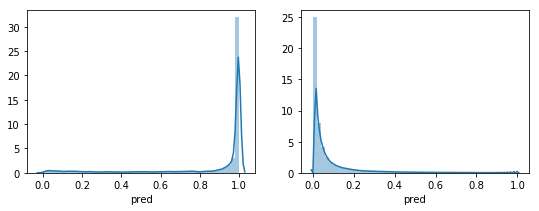

In [57]:

for hour in [4]: #, 5, 9, 10, 13, 14]:
    pos_cond = (val_df.hour==hour)&(val_df.is_attributed==1)
    neg_cond = (val_df.hour==hour)&(val_df.is_attributed==0)
    print(hour, len(val_df[(val_df.hour==hour)&(val_df.is_attributed==1)]))
    print(hour, val_df[pos_cond].pred.mean())
    print(hour, val_df[neg_cond].pred.mean())
    #df = val_df[val_df.hour==hour]
    #print(df.channel.value_counts())
    #print(val_df[pos_cond].channel.value_counts())
    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    sns.distplot(val_df[pos_cond].pred)
    plt.subplot(122)
    sns.distplot(val_df[neg_cond].pred)
    

In [63]:
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_colwidth', int(1e3))

pd.options.display.max_columns =999
pd.options.display.max_colwidth =999
pd.options.display.max_rows = 999

In [66]:
#sample false negatives
#val_df[(val_df.hour==hour)&(val_df.is_attributed==1)].sort_values(by='pred', ascending=True)
val_df[(val_df.hour==hour)&(val_df.is_attributed==1)].nextClick.mean()

8.7237203e+08

In [68]:
#val_df[(val_df.hour==hour)&(val_df.is_attributed==0)].nextClick.mean()

4

In [76]:
#val_df.groupby(by=['ip', 'app', 'device', 'os', 'channel']).nextClick.mean().reset_index().rename(columns={'nextClick': 'iadoc_mean_nc'}).head(10)

,ip,app,device,os,channel,iadoc_mean_nc
0,1,1,1,2,125,1.489762e+09
1,1,1,1,9,125,6.668000e+03
2,1,1,1,48,13,9.660400e+04
3,1,2,1,2,477,1.489804e+09
4,1,2,1,9,477,1.489804e+09
5,1,2,1,48,477,1.489776e+09
6,1,2,1,52,477,6.598200e+04
7,1,3,1,48,182,1.489776e+09
8,1,3,1,52,182,1.489776e+09
9,1,4,1,48,101,1.489776e+09


In [32]:
#g = lgb.create_tree_digraph(bst)
#g.render('digraph')

In [33]:
len(train_df)

134752480

In [49]:
val_df.head()

,app,channel,day,device,hour,ip,is_attributed,os,X0,X1,...,ip_tcount,ip_app_count,ip_app_os_count,ip_tchan_count,ip_app_os_var,ip_app_channel_var_day,ip_app_channel_mean_hour,nextClick,nextClick_shift,pred
62945075,11,487,9,1,0,201143,0,13,105,318,...,70,106,20,4.500000,28.589474,0.333333,4.500000,646.0,4145.0,0.053843
62945076,2,469,9,1,0,34684,0,13,100,293,...,54,134,17,3.583333,32.720589,0.553571,9.125000,32822.0,646.0,0.245441
62945077,26,477,9,1,0,207368,0,19,84,27,...,101,30,14,14.596980,38.109890,0.083333,8.500000,2175.0,32822.0,0.038973
62945078,18,121,9,1,0,110176,0,8,92,1,...,146,232,11,25.646624,48.654545,0.197551,11.160000,2285.0,2175.0,0.035226
62945079,12,265,9,1,0,109644,0,19,129,2789,...,393,2880,726,20.859743,26.591389,0.489841,10.512868,391.0,2285.0,0.024382


In [18]:
def predict(train_df, frm, to, predictors, bst, best_iteration=-1):
    len_train = to - frm    
    test_df = train_df[len_train:]
    
    print("Predicting...")
    click_ids = pd.read_csv('../input/test.csv', usecols=['click_id'])['click_id'].values
    
    sub = pd.DataFrame()    
    sub['click_id'] = click_ids
        
    gc.collect()
        
    sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
                            
    print("writing...")
    sub.to_csv('subm_000_{}.csv'.format(best_iteration), index=False, float_format='%.9f')
    print("done...")    

In [19]:
predict(train_df, frm, to, predictors, bst, 150) #subm22

Predicting...
writing...
done...


In [20]:
predict(train_df, frm, to, predictors, bst, 250) #subm23

Predicting...
writing...
done...


In [1]:
?? lgb.plot_importance(bst)

Object `lgb.plot_importance` not found.


In [8]:
"""
train 8, val 9.

predictors ['nextClick', 'nextClick_shift', 'app', 'device', 'os', 'channel', 'hour', 'ip_tcount', 'ip_tchan_count', 'ip_app_count', 'ip_app_os_count', 'ip_app_os_var', 'ip_app_channel_var_day', 'ip_app_channel_mean_hour', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'iadoc_mean_nc', 'ic_mean_nc']
train size:  62945075
valid size:  53016936
test size :  18790469
Training...
preparing validation datasets

/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/miniconda2/envs/talkingdata/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')

Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.977895	h4's auc: 0.971163	h5's auc: 0.97438	h9's auc: 0.970471	h10's auc: 0.970606	h13's auc: 0.973428	h14's auc: 0.9764
[20]	train's auc: 0.980686	h4's auc: 0.973893	h5's auc: 0.977452	h9's auc: 0.973509	h10's auc: 0.974101	h13's auc: 0.976995	h14's auc: 0.979761
[30]	train's auc: 0.98312	h4's auc: 0.976222	h5's auc: 0.979035	h9's auc: 0.976013	h10's auc: 0.976945	h13's auc: 0.980206	h14's auc: 0.982716
[40]	train's auc: 0.984209	h4's auc: 0.976971	h5's auc: 0.979663	h9's auc: 0.976832	h10's auc: 0.977767	h13's auc: 0.981243	h14's auc: 0.983945
[50]	train's auc: 0.984884	h4's auc: 0.977545	h5's auc: 0.980071	h9's auc: 0.977247	h10's auc: 0.978295	h13's auc: 0.981897	h14's auc: 0.98456
[60]	train's auc: 0.985377	h4's auc: 0.977806	h5's auc: 0.980306	h9's auc: 0.977475	h10's auc: 0.978551	h13's auc: 0.982054	h14's auc: 0.984701
[70]	train's auc: 0.985759	h4's auc: 0.978028	h5's auc: 0.980465	h9's auc: 0.97768	h10's auc: 0.97879	h13's auc: 0.982226	h14's auc: 0.984943
[80]	train's auc: 0.986073	h4's auc: 0.978208	h5's auc: 0.980633	h9's auc: 0.977835	h10's auc: 0.979046	h13's auc: 0.982499	h14's auc: 0.9852
[90]	train's auc: 0.986432	h4's auc: 0.978484	h5's auc: 0.980798	h9's auc: 0.978007	h10's auc: 0.979275	h13's auc: 0.982624	h14's auc: 0.985398
[100]	train's auc: 0.986661	h4's auc: 0.978508	h5's auc: 0.980848	h9's auc: 0.978097	h10's auc: 0.979425	h13's auc: 0.98272	h14's auc: 0.985552
[110]	train's auc: 0.986887	h4's auc: 0.978546	h5's auc: 0.980848	h9's auc: 0.978135	h10's auc: 0.979446	h13's auc: 0.982803	h14's auc: 0.985454
[120]	train's auc: 0.987029	h4's auc: 0.978548	h5's auc: 0.980859	h9's auc: 0.978169	h10's auc: 0.979456	h13's auc: 0.982852	h14's auc: 0.985488
[130]	train's auc: 0.987199	h4's auc: 0.978617	h5's auc: 0.980838	h9's auc: 0.978158	h10's auc: 0.979541	h13's auc: 0.982874	h14's auc: 0.985546
[140]	train's auc: 0.987327	h4's auc: 0.978599	h5's auc: 0.980839	h9's auc: 0.978113	h10's auc: 0.979558	h13's auc: 0.982942	h14's auc: 0.985528
Early stopping, best iteration is:
[119]	train's auc: 0.987025	h4's auc: 0.978566	h5's auc: 0.980888	h9's auc: 0.978164	h10's auc: 0.979466	h13's auc: 0.982854	h14's auc: 0.985492

Model Report
bst1.best_iteration:  119
[1799.3604636192322]: model training time


"""